Cell 1: 라이브러리 임포트 및 설정

In [119]:
# Cell 1
# %matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import itertools

print("Libraries imported successfully.")

Libraries imported successfully.


Cell 2: 격자 구조 정의 함수

In [120]:
# Cell 2
def get_neighbor_vectors(lattice_type):
    """
    각 격자(lattice_type)에 대해 J1(최인접), J2(차인접) 변위 벡터들을 반환합니다.
    """
    lattice_type = lattice_type.lower()
    vectors_j1 = []
    vectors_j2 = []

    if lattice_type == 'sc':
        # J1: 6 neighbors (±1, 0, 0)...
        for i in range(3):
            v = np.zeros(3); v[i] = 1.0; vectors_j1.append(v)
            v = np.zeros(3); v[i] = -1.0; vectors_j1.append(v)
        # J2: 12 neighbors (±1, ±1, 0)...
        for x in [-1, 1]:
            for y in [-1, 1]:
                vectors_j2.append(np.array([x, y, 0.0]))
                vectors_j2.append(np.array([x, 0.0, y]))
                vectors_j2.append(np.array([0.0, x, y]))

    elif lattice_type == 'bcc':
        # BCC: J1 (±0.5, ±0.5, ±0.5) -> 8개
        for x in [-0.5, 0.5]:
            for y in [-0.5, 0.5]:
                for z in [-0.5, 0.5]:
                    vectors_j1.append(np.array([x, y, z]))
        # J2 (±1, 0, 0) -> 6개
        for i in range(3):
            v = np.zeros(3); v[i] = 1.0; vectors_j2.append(v)
            v = np.zeros(3); v[i] = -1.0; vectors_j2.append(v)

    elif lattice_type == 'fcc':
        # FCC: J1 (±0.5, ±0.5, 0) 등 -> 12개
        for x in [-0.5, 0.5]:
            for y in [-0.5, 0.5]:
                vectors_j1.append(np.array([x, y, 0.0]))
                vectors_j1.append(np.array([x, 0.0, y]))
                vectors_j1.append(np.array([0.0, x, y]))
        # J2 (±1, 0, 0) -> 6개
        for i in range(3):
            v = np.zeros(3); v[i] = 1.0; vectors_j2.append(v)
            v = np.zeros(3); v[i] = -1.0; vectors_j2.append(v)

    else:
        raise ValueError("Unknown lattice type. Choose 'sc', 'bcc', or 'fcc'.")

    return vectors_j1, vectors_j2

def get_basis_atoms(lattice_type):
    """각 격자의 Conventional Cell 내 원자 위치"""
    if lattice_type == 'sc':
        return [np.array([0.0, 0.0, 0.0])]
    elif lattice_type == 'bcc':
        return [np.array([0.0, 0.0, 0.0]), np.array([0.5, 0.5, 0.5])]
    elif lattice_type == 'fcc':
        return [np.array([0.0, 0.0, 0.0]), np.array([0.5, 0.5, 0.0]),
                np.array([0.5, 0.0, 0.5]), np.array([0.0, 0.5, 0.5])]
    return []

Cell 3: Heisenberg3D 클래스 (시뮬레이션 로직)

In [121]:
# Cell 3 (Update): 외부 자기장 B_ext 추가 버전

class Heisenberg3D:
    def __init__(self, L, T, J1, J2_ratio, lattice_type="sc", B_ext=np.array([0,0,0])):
        self.L = L
        self.T = T
        self.beta = 1.0 / T if T > 1e-9 else 1e9
        self.J1 = J1
        self.J2 = J1 * J2_ratio
        self.lattice_type = lattice_type
        # 외부 자기장 추가 (벡터)
        self.B_ext = np.array(B_ext, dtype=float)
        
        # 격자 및 이웃 생성
        self.basis = get_basis_atoms(lattice_type)
        self.n_basis = len(self.basis)
        self.N_sites = self.n_basis * (L**3)
        self.spins = self._random_spins(self.N_sites)
        
        print(f"Building neighbor table for {lattice_type.upper()}...")
        self.nbr_j1, self.nbr_j2 = self._build_neighbor_table_fast()
        
        self.M_vec = np.sum(self.spins, axis=0)
        self.mag_history = []

    def _random_spins(self, n):
        z = np.random.uniform(-1, 1, n)
        phi = np.random.uniform(0, 2*np.pi, n)
        sin_theta = np.sqrt(1 - z**2)
        return np.column_stack((sin_theta*np.cos(phi), sin_theta*np.sin(phi), z))

    def _build_neighbor_table_fast(self):
        # (기존과 동일하여 생략, 위 코드 그대로 사용됨)
        vec_j1, vec_j2 = get_neighbor_vectors(self.lattice_type)
        nbr_table_j1 = []
        nbr_table_j2 = []
        def get_idx(x, y, z, b):
            return b + self.n_basis * ((x%self.L) + self.L * ((y%self.L) + self.L * (z%self.L)))
        
        for z in range(self.L):
            for y in range(self.L):
                for x in range(self.L):
                    for b in range(self.n_basis):
                        current_pos = np.array([x, y, z]) + self.basis[b]
                        
                        # J1
                        row_j1 = []
                        for v in vec_j1:
                            target_pos = current_pos + v
                            t_cell = np.floor(target_pos + 1e-5).astype(int)
                            t_rem = target_pos - t_cell
                            best_b = np.argmin([np.linalg.norm(t_rem - bb) for bb in self.basis])
                            row_j1.append(get_idx(t_cell[0], t_cell[1], t_cell[2], best_b))
                        nbr_table_j1.append(row_j1)

                        # J2
                        row_j2 = []
                        for v in vec_j2:
                            target_pos = current_pos + v
                            t_cell = np.floor(target_pos + 1e-5).astype(int)
                            t_rem = target_pos - t_cell
                            best_b = np.argmin([np.linalg.norm(t_rem - bb) for bb in self.basis])
                            row_j2.append(get_idx(t_cell[0], t_cell[1], t_cell[2], best_b))
                        nbr_table_j2.append(row_j2)
        return np.array(nbr_table_j1), np.array(nbr_table_j2)

    def heat_bath_step(self):
        indices = np.random.permutation(self.N_sites)
        for i in indices:
            j1_idxs = self.nbr_j1[i]
            j2_idxs = self.nbr_j2[i]
            
            # 국소장 계산: 이웃 스핀 합 + 외부 자기장 B_ext 포함!
            h = self.J1 * np.sum(self.spins[j1_idxs], axis=0) + \
                self.J2 * np.sum(self.spins[j2_idxs], axis=0) + \
                self.B_ext
                
            h_norm = np.linalg.norm(h)
            old_spin = self.spins[i].copy()

            if h_norm < 1e-10:
                new_spin = self._random_spins(1).flatten()
            else:
                beta_h = self.beta * h_norm
                h_hat = h / h_norm
                
                # 수식 이미지와 동일한 로직
                r = np.random.random()
                if beta_h > 50:
                    mu = 1.0 + np.log(r + (1-r)*np.exp(-2*beta_h)) / beta_h
                elif beta_h < 1e-4:
                    mu = 2*r - 1
                else:
                    exp_bh = np.exp(beta_h)
                    exp_mbh = np.exp(-beta_h)
                    mu = (1.0 / beta_h) * np.log(exp_mbh + r * (exp_bh - exp_mbh))
                
                mu = np.clip(mu, -1.0, 1.0)
                sin_theta = np.sqrt(1 - mu**2)
                phi = 2 * np.pi * np.random.random()
                
                # 좌표축 변환 (Gram-Schmidt)
                if abs(h_hat[0]) < 0.9: ax_temp = np.array([1, 0, 0])
                else: ax_temp = np.array([0, 1, 0])
                
                u_vec = np.cross(h_hat, ax_temp)
                u_vec /= np.linalg.norm(u_vec)
                v_vec = np.cross(h_hat, u_vec)
                
                new_spin = (mu * h_hat) + (sin_theta * np.cos(phi) * u_vec) + (sin_theta * np.sin(phi) * v_vec)
            
            self.spins[i] = new_spin / np.linalg.norm(new_spin)
            self.M_vec += (self.spins[i] - old_spin)

    def run(self, sweeps=100):
        print(f"Running {sweeps} sweeps...")
        for s in range(sweeps):
            self.heat_bath_step()
            self.mag_history.append(np.linalg.norm(self.M_vec) / self.N_sites)
        print("Done.")

Cell 4: 3D 시각화 함수

In [122]:
# Cell 4 (최종 수정): 스핀 + 1x1x1 단위 격자(Unit Cell Box) 그리기

def plot_system(model, title="Spin Configuration"):
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    L = model.L
    
    # 1. 1x1x1 단위 격자 (Grid Box) 그리기
    # 스핀들이 어디에 박혀있는지 알 수 있게 '빈 상자'들을 그립니다.
    # x, y, z 축 방향으로 평행한 선들을 긋습니다.
    
    grid_color = 'gray'
    grid_alpha = 0.3
    grid_lw = 0.5
    
    # 격자가 너무 조밀하면 보기 힘드므로 L이 적당할 때만 그립니다.
    if L <= 10:
        # X축 방향 선들 (변하는 건 x, 고정된 건 y, z)
        for y in range(L + 1):
            for z in range(L + 1):
                ax.plot([0, L], [y, y], [z, z], color=grid_color, alpha=grid_alpha, lw=grid_lw)
        
        # Y축 방향 선들
        for x in range(L + 1):
            for z in range(L + 1):
                ax.plot([x, x], [0, L], [z, z], color=grid_color, alpha=grid_alpha, lw=grid_lw)
                
        # Z축 방향 선들
        for x in range(L + 1):
            for y in range(L + 1):
                ax.plot([x, x], [y, y], [0, L], color=grid_color, alpha=grid_alpha, lw=grid_lw)
    else:
        # L이 너무 크면 외곽 박스만 그립니다.
        ax.plot([0, L], [0, 0], [0, 0], color='k'); ax.plot([0, L], [L, L], [L, L], color='k') 
        # (생략: 큰 L에 대한 처리는 복잡해지니 간단히 넘어갑니다)

    # 2. 스핀 좌표 및 벡터 준비
    # 전체 다 그리면 느릴 수 있으니 샘플링
    coords = []
    for z in range(model.L):
        for y in range(model.L):
            for x in range(model.L):
                for b_vec in model.basis:
                    coords.append(np.array([x, y, z]) + b_vec)
    coords = np.array(coords)
    
    if model.N_sites > 2000:
        idx = np.random.choice(model.N_sites, 2000, replace=False)
        plot_coords = coords[idx]
        plot_spins = model.spins[idx]
    else:
        plot_coords = coords
        plot_spins = model.spins

    X, Y, Z = plot_coords[:, 0], plot_coords[:, 1], plot_coords[:, 2]
    U, V, W = plot_spins[:, 0], plot_spins[:, 1], plot_spins[:, 2]
    
    # 3. 색상 (자화 방향 정렬도)
    M_vec = model.M_vec
    M_norm = np.linalg.norm(M_vec)
    if M_norm > 1e-6:
        M_hat = M_vec / M_norm
        colors_val = np.sum(plot_spins * M_hat, axis=1)
        label_text = r"Alignment with $\vec{M}$"
    else:
        colors_val = W 
        label_text = r"$S_z$"
        
    norm = Normalize(vmin=-1, vmax=1)
    cmap = cm.jet 
    
    # 4. 화살표 그리기
    # pivot='middle'로 해야 스핀 중심이 격자점 위에 옵니다.
    q = ax.quiver(X, Y, Z, U, V, W, length=0.5, normalize=True,
                  cmap=cmap, array=colors_val, pivot='middle')
    q.set_clim(-1, 1)
        
    cbar = plt.colorbar(q, ax=ax, shrink=0.6)
    cbar.set_label(label_text)
    
    ax.set_title(f"{title}\n(Lattice Grid View)")
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_zlim(0, L)
    ax.set_box_aspect([1,1,1])
    
    plt.tight_layout()
    plt.show()

Cell 5: 시뮬레이션 실행 (설정 변경하는 곳)

Building neighbor table for BCC...
Running 50 sweeps...
Done.


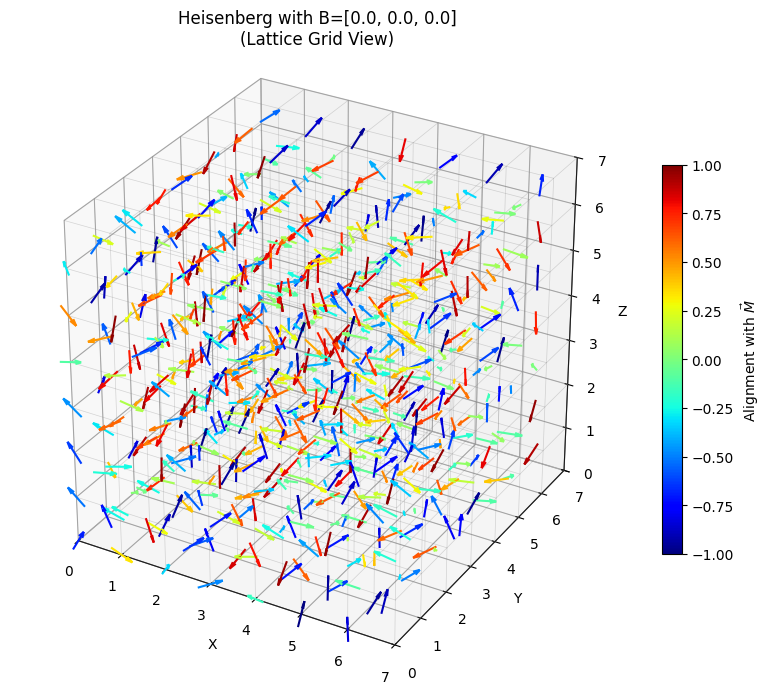

In [123]:
# Cell 5 (Test)
LATTICE_TYPE = "bcc"  
L = 7
T = 5
B_field = [0.0, 0.0, 0.0] # <--- [중요] 자기장

sim = Heisenberg3D(L=L, T=T, J1=1.0, J2_ratio=0.0, lattice_type=LATTICE_TYPE, B_ext=B_field)
sim.run(sweeps=50)

# 시각화
plot_system(sim, title=f"Heisenberg with B={B_field}")

Cell 6: 자화율 그래프 확인

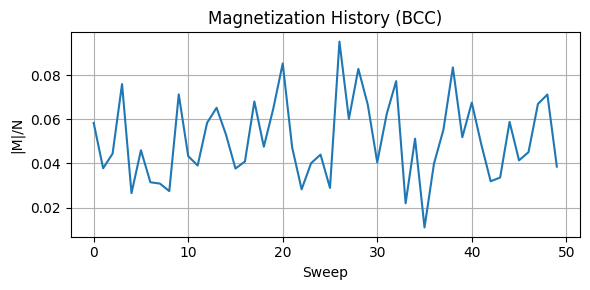

In [124]:
# Cell 6
plt.figure(figsize=(6, 3))
plt.plot(sim.mag_history)
plt.title(f"Magnetization History ({LATTICE_TYPE.upper()})")
plt.xlabel("Sweep")
plt.ylabel("|M|/N")
plt.grid(True)
plt.tight_layout()
plt.show()

Cell 8: 상전이 분석 (Temperature Sweep)

<>:133: SyntaxWarning: invalid escape sequence '\l'
<>:133: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_47128/3393602899.py:133: SyntaxWarning: invalid escape sequence '\l'
  axes[0, 0].set_ylabel(r'$\langle |M| \rangle / N$')


Starting Temperature Sweep (15 points)...
Lattice: BCC, L=7


  0%|          | 0/15 [00:00<?, ?it/s]

Building neighbor table for BCC...


  7%|▋         | 1/15 [00:27<06:24, 27.49s/it]

Building neighbor table for BCC...


 13%|█▎        | 2/15 [00:54<05:57, 27.49s/it]

Building neighbor table for BCC...


 20%|██        | 3/15 [01:22<05:30, 27.53s/it]

Building neighbor table for BCC...


 27%|██▋       | 4/15 [01:50<05:03, 27.64s/it]

Building neighbor table for BCC...


 33%|███▎      | 5/15 [02:18<04:36, 27.68s/it]

Building neighbor table for BCC...


 40%|████      | 6/15 [02:46<04:09, 27.76s/it]

Building neighbor table for BCC...


 47%|████▋     | 7/15 [03:13<03:42, 27.80s/it]

Building neighbor table for BCC...


 53%|█████▎    | 8/15 [03:41<03:14, 27.79s/it]

Building neighbor table for BCC...


 60%|██████    | 9/15 [04:09<02:46, 27.79s/it]

Building neighbor table for BCC...


 67%|██████▋   | 10/15 [04:37<02:18, 27.75s/it]

Building neighbor table for BCC...


 73%|███████▎  | 11/15 [05:04<01:50, 27.70s/it]

Building neighbor table for BCC...


 80%|████████  | 12/15 [05:32<01:23, 27.71s/it]

Building neighbor table for BCC...


 87%|████████▋ | 13/15 [06:00<00:55, 27.69s/it]

Building neighbor table for BCC...


 93%|█████████▎| 14/15 [06:27<00:27, 27.68s/it]

Building neighbor table for BCC...


100%|██████████| 15/15 [06:55<00:00, 27.70s/it]

Sweep Completed!


Text(0.5, 1.0, 'Magnetic Susceptibility')

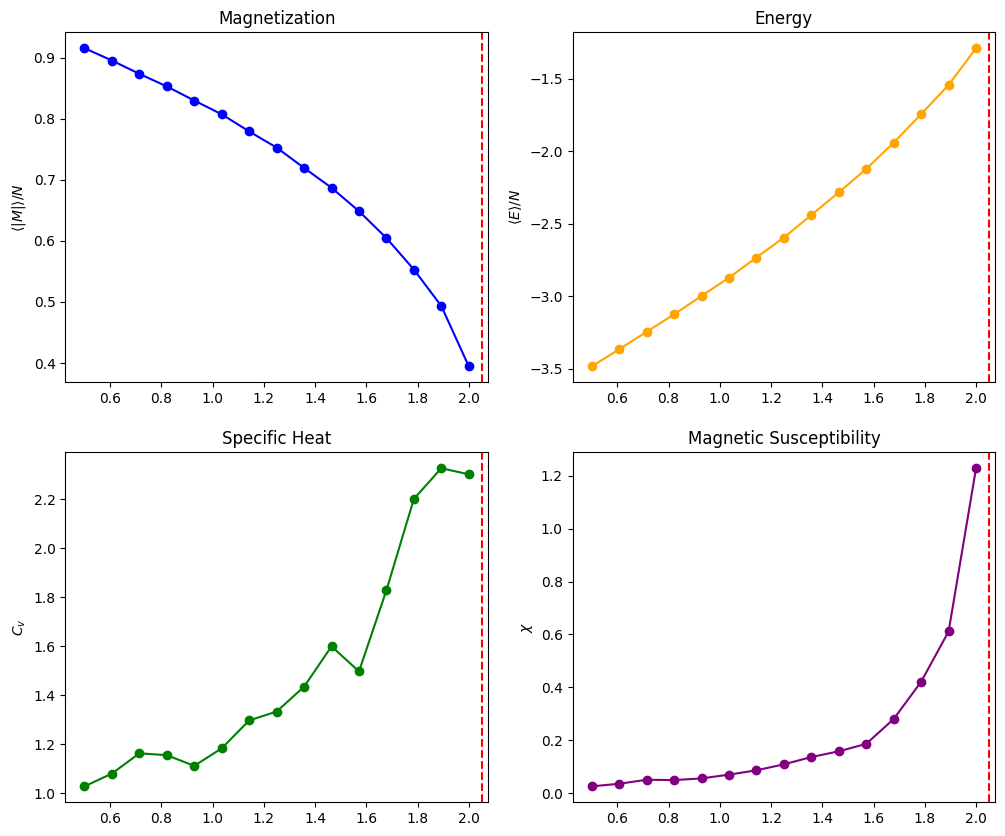

In [125]:
# Cell 8: Phase Transition Analysis (T sweep)
from tqdm import tqdm  # 진행상황 표시용

# 1. 시스템 에너지를 계산하는 함수 (벡터 내적)
def get_total_energy(model):
    """
    현재 스핀 배치의 총 에너지를 계산합니다.
    H = -J1 * sum(S_i . S_j) - J2 * ...
    """
    E = 0.0
    
    # Vectorized computation using neighbor tables
    # J1 Energy
    # 모든 스핀(N, 3)과 그 이웃들의 합(N, 3)을 내적
    # 주의: nbr_j1은 (N, neighbor_count) 형태
    
    # 이웃 스핀들의 벡터 합 계산
    # fancy indexing: model.spins[model.nbr_j1] -> (N, 6, 3)
    sum_nbr_j1 = np.sum(model.spins[model.nbr_j1], axis=1) # (N, 3)
    
    # 자기 자신과 이웃의 합을 내적 (S_i . sum(S_j))
    # element-wise multiply 후 sum axis=1
    dot_j1 = np.sum(model.spins * sum_nbr_j1, axis=1)
    
    # 총합 (double counting 방지를 위해 0.5 곱함)
    E += -0.5 * model.J1 * np.sum(dot_j1)
    
    # J2 Energy (만약 있다면)
    if model.J2 != 0:
        sum_nbr_j2 = np.sum(model.spins[model.nbr_j2], axis=1)
        dot_j2 = np.sum(model.spins * sum_nbr_j2, axis=1)
        E += -0.5 * model.J2 * np.sum(dot_j2)
        
    # External Field Energy (H = - B . S)
    if hasattr(model, 'B_ext') and np.linalg.norm(model.B_ext) > 0:
        mag_dot_B = np.dot(model.M_vec, model.B_ext) # Total M . B
        E -= mag_dot_B
        
    return E

# === 파라미터 설정 === 온도 범위, J1, J2 등 설정 가능 
# SC 격자의 이론적 Tc는 약 1.44 입니다. 이 주변을 조밀하게 봅니다.
temps = np.linspace(0.5, 2.0, 15)  
L_sweep = 7       # 격자가 클수록 정확하지만 느려짐 (6~8 추천)
sweeps_measure = 500  # 측정 횟수
sweeps_warmup = 200   # 평형 도달 시간

# 결과 저장용 리스트
M_list = []
E_list = []
Cv_list = []
Chi_list = []

print(f"Starting Temperature Sweep ({len(temps)} points)...")
print(f"Lattice: {LATTICE_TYPE.upper()}, L={L_sweep}")

for T in tqdm(temps):
    # 모델 초기화 (이전 Cell의 클래스 사용)
    # J2_RATIO 등은 전역 변수나 직접 입력
    model = Heisenberg3D(L=L_sweep, T=T, J1=1.0, J2_ratio=0.0, lattice_type=LATTICE_TYPE)
    
    # 1. Thermalization (평형 도달)
    for _ in range(sweeps_warmup):
        model.heat_bath_step()
        
    # 2. Measurement Loop
    m_vals = []
    e_vals = []
    
    for _ in range(sweeps_measure):
        model.heat_bath_step()
        
        # 1 sweep마다 기록 (상관관계 줄이려면 record_interval 둘 수 있음)
        
        # Magnetization (|M| per spin)
        m = np.linalg.norm(model.M_vec) / model.N_sites
        m_vals.append(m)
        
        # Energy (per spin) -> 계산 비용이 좀 듬
        e = get_total_energy(model) / model.N_sites
        e_vals.append(e)
        
    # Numpy array 변환
    m_vals = np.array(m_vals)
    e_vals = np.array(e_vals)
    
    # --- 통계량 계산 ---
    
    # 1. <|M|>
    M_mean = np.mean(m_vals)
    M_list.append(M_mean)
    
    # 2. <E>
    E_mean = np.mean(e_vals)
    E_list.append(E_mean)
    
    # 3. Specific Heat (Cv)
    # Cv = (<E^2> - <E>^2) / T^2  (k_B = 1)
    # N을 곱해야 하는지 나누어야 하는지 헷갈릴 수 있는데, 
    # 위에서 e_vals를 이미 'per spin'으로 구했으므로
    # 공식: N * (<e^2> - <e>^2) / T^2 가 됨.
    e_var = np.var(e_vals) # 분산 (<e^2> - <e>^2)
    Cv = (model.N_sites * e_var) / (T**2)
    Cv_list.append(Cv)
    
    # 4. Susceptibility (Chi)
    # Chi = (<M^2> - <M>^2) / T  (여기서 M은 Total M이 아니라 |M| per spin 기준)
    # 공식: N * (<m^2> - <m>^2) / T
    m_var = np.var(m_vals)
    Chi = (model.N_sites * m_var) / T
    Chi_list.append(Chi)

print("Sweep Completed!")

# === 그래프 그리기 ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Tc_theoretical = 1.44  # For SC lattice Heisenberg

Tc_dict = {
    "sc":  1.44,
    "bcc": 2.05,
    "fcc": 3.18,
}

# 위에서 썼던 LATTICE_TYPE 또는 model.lattice_type 사용
lat = LATTICE_TYPE.lower()  # 예: "sc", "bcc", "fcc"
Tc_theoretical = Tc_dict.get(lat, None)

"""
# 1. Magnetization
axes[0, 0].plot(temps, M_list, 'o-', color='blue', label='Simulation')
axes[0, 0].axvline(x=Tc_theoretical, color='red', linestyle='--', label='SC Theoretical Tc')
axes[0, 0].set_ylabel(r'$\langle |M| \rangle / N$')
axes[0, 0].set_title('Magnetization')

# 2. Energy
axes[0, 1].plot(temps, E_list, 'o-', color='orange')
axes[0, 1].axvline(x=Tc_theoretical, color='red', linestyle='--')
axes[0, 1].set_ylabel(r'$\langle E \rangle / N$')
axes[0, 1].set_title('Energy')

# 3. Specific Heat
axes[1, 0].plot(temps, Cv_list, 'o-', color='green')
axes[1, 0].axvline(x=Tc_theoretical, color='red', linestyle='--')
axes[1, 0].set_ylabel(r'$C_v$')
axes[1, 0].set_title('Specific Heat')

# 4. Susceptibility
axes[1, 1].plot(temps, Chi_list, 'o-', color='purple')
axes[1, 1].axvline(x=Tc_theoretical, color='red', linestyle='--')
axes[1, 1].set_ylabel(r'$\chi$')
axes[1, 1].set_title('Magnetic Susceptibility')

for ax in axes.flatten():
    ax.set_xlabel('Temperature (T)')
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show() """

# 1. Magnetization
axes[0, 0].plot(temps, M_list, 'o-', color='blue', label='Simulation')
if Tc_theoretical is not None:
    axes[0, 0].axvline(x=Tc_theoretical, color='red', linestyle='--', label=f'{lat.upper()} Theoretical Tc')
axes[0, 0].set_ylabel(r'$\langle |M| \rangle / N$')
axes[0, 0].set_title('Magnetization')

# 2. Energy
axes[0, 1].plot(temps, E_list, 'o-', color='orange')
if Tc_theoretical is not None:
    axes[0, 1].axvline(x=Tc_theoretical, color='red', linestyle='--')
axes[0, 1].set_ylabel(r'$\langle E \rangle / N$')
axes[0, 1].set_title('Energy')

# 3. Specific Heat
axes[1, 0].plot(temps, Cv_list, 'o-', color='green')
if Tc_theoretical is not None:
    axes[1, 0].axvline(x=Tc_theoretical, color='red', linestyle='--')
axes[1, 0].set_ylabel(r'$C_v$')
axes[1, 0].set_title('Specific Heat')

# 4. Susceptibility
axes[1, 1].plot(temps, Chi_list, 'o-', color='purple')
if Tc_theoretical is not None:
    axes[1, 1].axvline(x=Tc_theoretical, color='red', linestyle='--')
axes[1, 1].set_ylabel(r'$\chi$')
axes[1, 1].set_title('Magnetic Susceptibility')

Cell 10: Landau Theory Analysis & Free Energy Landscape

--- Landau Fit Results ---
Fitted Tc: 2.4279 (Simulation Data)
Fitted Coefficient A: 0.6777


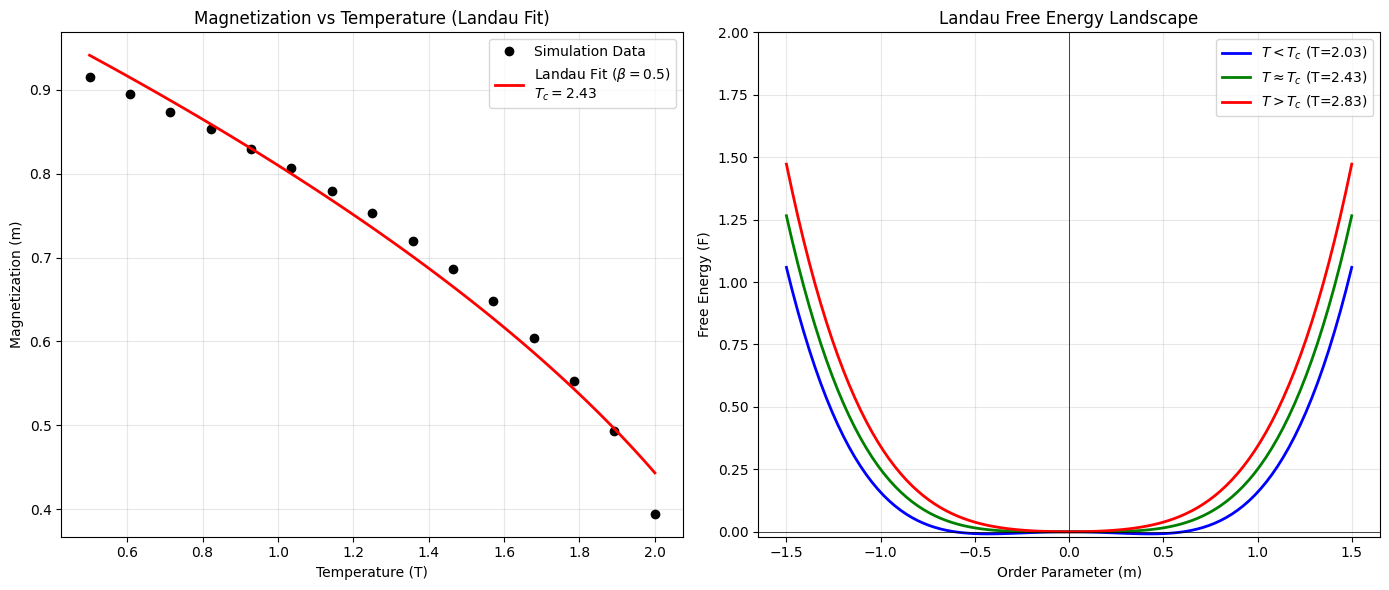

In [126]:
# Cell 10: Landau Theory Analysis & Free Energy Landscape
from scipy.optimize import curve_fit

def landau_magnetization(T, Tc, A):
    """
    란다우 이론에 따른 자화율 피팅 함수 
    m ~ (Tc - T)^(1/2) for T < Tc
    m = 0              for T >= Tc
    """
    m = np.zeros_like(T)
    indices = T < Tc
    m[indices] = A * np.sqrt(Tc - T[indices])
    return m


Tc_dict = {
    "sc":  1.44,
    "bcc": 2.05,
    "fcc": 3.18,
}

lat = LATTICE_TYPE.lower()
Tc_guess = Tc_dict[lat]

# 1. 시뮬레이션 데이터 가져오기 (Cell 8의 결과가 있어야 함)
# temps, M_list (numpy array로 변환)
T_data = np.array(temps)
M_data = np.array(M_list)

# 2. 피팅 수행 (Tc와 비례상수 A 찾기)
# 초기 추정값 (p0): [Tc 추정치, A 추정치]
# SC 격자 이론 Tc=1.44 근처, A는 대략 1.0
try:
    popt, pcov = curve_fit(landau_magnetization, T_data, M_data, p0=[Tc_guess, 1.0], maxfev=5000)
    Tc_fit, A_fit = popt
    print(f"--- Landau Fit Results ---")
    print(f"Fitted Tc: {Tc_fit:.4f} (Simulation Data)")
    print(f"Fitted Coefficient A: {A_fit:.4f}")
except Exception as e :
    print("Fitting failed:",e)
    print("Using theoretical Tc guess for this lattice.")
    Tc_fit = Tc_guess
    A_fit = 1.0

# 3. 란다우 자유 에너지 곡선 그리기 [cite: 84, 159]
# F(m) = (1/2)*a0*(T-Tc)*m^2 + (1/4)*b*m^4
# 평형 상태에서 m_0 = sqrt(a0/b * (Tc-T)) 이므로,
# 위에서 구한 A_fit = sqrt(a0/b) 입니다. 
# 편의상 b=1.0으로 고정하고 a0를 역산해서 상대적인 모양을 봅니다.
b_fixed = 1.0
a0_derived = (A_fit**2) * b_fixed

def landau_free_energy(m, T, Tc, a0, b):
    # F = F0 + (1/2)a(T-Tc)m^2 + (1/4)bm^4 
    return 0.5 * a0 * (T - Tc) * m**2 + 0.25 * b * m**4

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# (왼쪽) M-T 데이터와 란다우 피팅 비교 [cite: 44, 69]
axes[0].plot(T_data, M_data, 'ko', label='Simulation Data')
T_smooth = np.linspace(min(T_data), max(T_data), 100)
axes[0].plot(T_smooth, landau_magnetization(T_smooth, Tc_fit, A_fit), 'r-', lw=2, label=f'Landau Fit ($\\beta=0.5$)\n$T_c={Tc_fit:.2f}$')
axes[0].set_xlabel('Temperature (T)')
axes[0].set_ylabel('Magnetization (m)')
axes[0].set_title('Magnetization vs Temperature (Landau Fit)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# (오른쪽) 자유 에너지 랜드스케이프 (Free Energy Landscape) [cite: 84, 175]
m_range = np.linspace(-1.5, 1.5, 100)
# 세 가지 온도 지점에서 그리기: T < Tc, T ~ Tc, T > Tc
sample_temps = [Tc_fit - 0.4, Tc_fit, Tc_fit + 0.4]
colors = ['blue', 'green', 'red']
labels = [r'$T < T_c$', r'$T \approx T_c$', r'$T > T_c$']

for T_val, col, lab in zip(sample_temps, colors, labels):
    F_vals = landau_free_energy(m_range, T_val, Tc_fit, a0_derived, b_fixed)
    axes[1].plot(m_range, F_vals, color=col, linewidth=2, label=f'{lab} (T={T_val:.2f})')

axes[1].axhline(0, color='black', lw=0.5)
axes[1].axvline(0, color='black', lw=0.5)
axes[1].set_xlabel('Order Parameter (m)')
axes[1].set_ylabel('Free Energy (F)')
axes[1].set_title('Landau Free Energy Landscape')
axes[1].legend()
axes[1].grid(alpha=0.3)
# Y축 범위 제한 (그래프가 너무 위로 솟는 것 방지)
axes[1].set_ylim(min(landau_free_energy(m_range, Tc_fit-0.5, Tc_fit, a0_derived, b_fixed))*1.5, 2.0)

plt.tight_layout()
plt.show()

Cell 11: 자유 에너지 직접 추출 (Histogram Method)

In [127]:
"""
# Cell 11: Direct Free Energy Extraction via Histogram Method
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def get_free_energy_landscape_direct(model, measure_sweeps=50000):
    """
    고정된 온도에서 m의 분포 P(m)을 구하고,
    F(m) = -T * ln(P(m)) 공식을 통해 자유 에너지를 직접 계산함.
    """
    m_history = []
    
    # 1. 충분한 샘플링 (오래 돌려야 분포가 예쁘게 나옵니다)
    # Thermalization
    for _ in range(1000):
        model.heat_bath_step()
        
    # Measurement
    # 샘플 간 상관관계를 줄이기 위해 step을 둠
    for _ in range(measure_sweeps):
        model.heat_bath_step()
        m = np.linalg.norm(model.M_vec) / model.N_sites
        m_history.append(m)
        
    m_history = np.array(m_history)
    
    # 2. 히스토그램 생성 (P(m))
    # m은 0~1 사이 값이므로 적당한 bin으로 나눔
    counts, bin_edges = np.histogram(m_history, bins=50, range=(0, 1.1), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # 3. 자유 에너지 변환: F = -T * ln(P)
    # counts가 0인 경우 log(0) 에러 방지를 위해 아주 작은 값 더함
    safe_counts = counts + 1e-10
    F_m = -model.T * np.log(safe_counts)
    
    # 그래프를 예쁘게 보기 위해 최솟값을 0으로 맞춤 (상대적 에너지가 중요하므로)
    F_m = F_m - np.min(F_m)
    
    return bin_centers, F_m

# === 분석 실행 ===
# 3가지 온도 지점에서 확인 (Tc 추정값 1.44 기준)
# 1. 저온 (T < Tc): 자발적 대칭 깨짐 -> m > 0 에서 우물 발생
# 2. 임계점 (T ~ Tc): 바닥이 평평해지기 시작
# 3. 고온 (T > Tc): 무질서 -> m = 0 근처가 가장 안정 (단, 3D 벡터라 |m|은 0보다 살짝 큼)

Tc_est = 1.44
test_temps = [1.0, 1.44, 2.0] # [저온, 임계, 고온]
labels = [r'$T < T_c$ (Ordered)', r'$T \approx T_c$ (Critical)', r'$T > T_c$ (Disordered)']
colors = ['blue', 'green', 'red']

L_landscape = 6  # 격자가 작아야 요동(Fluctuation)이 커서 전체 분포를 보기 좋음

fig, ax = plt.subplots(figsize=(8, 6))

print(f"Running Histogram Method for {LATTICE_TYPE.upper()} (L={L_landscape})...")
print("This may take a minute because we need MANY samples!")

for T_val, label, col in zip(test_temps, labels, colors):
    print(f"Sampling at T = {T_val}...")
    # 모델 생성
    model = Heisenberg3D(L=L_landscape, T=T_val, J1=1.0, J2_ratio=J2_RATIO, lattice_type=LATTICE_TYPE)
    
    # 자유 에너지 추출
    m_vals, F_vals = get_free_energy_landscape_direct(model, measure_sweeps=30000)
    
    # --- 시각화 트릭 ---
    # 시뮬레이션에서는 |M| (벡터 크기)만 나오므로 항상 양수입니다.
    # 하지만 란다우 이론 그래프(PDF 6쪽)처럼 대칭적으로(W 모양) 보여주기 위해
    # 데이터를 좌우 대칭(-m, +m)으로 복사해서 그립니다.
    
    # 원본(양수) + 대칭(음수)
    m_sym = np.concatenate([-m_vals[::-1], m_vals])
    F_sym = np.concatenate([F_vals[::-1], F_vals])
    
    # 스무딩(부드럽게) 처리해서 그리기
    ax.plot(m_sym, F_sym, color=col, linewidth=2, label=f"{label} (T={T_val})")

# 그래프 꾸미기
ax.set_title(f"Directly Extracted Free Energy Landscape ({LATTICE_TYPE.upper()})\n$F(m) = -k_B T \ln P(m)$", fontsize=14)
ax.set_xlabel("Magnetization Order Parameter ($m$)", fontsize=12)
ax.set_ylabel("Free Energy ($F$)", fontsize=12)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(0, 1.5) # Y축 범위는 상황에 따라 조절
ax.axhline(0, color='k', lw=0.5)
ax.axvline(0, color='k', lw=0.5)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
""" 
#시간 너무 오래걸려 말안돼.

IndentationError: unexpected indent (4268440841.py, line 9)